In [205]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


In [206]:
plt.rcParams["figure.figsize"] = (10,5)

In [207]:
dataset= pd.read_csv("dataset.csv")
# drop the iron concetration column, as we are not allowed to use it
dataset.drop("% Iron Concentrate", axis=1)

dataset["date"] = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')

for col in dataset.columns[1:]:
    dataset[col] = dataset[col].apply(lambda x: x.replace(",", "."))
    dataset[col] = dataset[col].astype(float)

dataset

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,...,313.695,392.160,430.702,872.008,418.725,497.548,446.357,416.892,64.27,1.71
737449,2017-09-09 23:00:00,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,...,236.700,401.505,404.616,864.409,418.377,506.398,372.995,426.337,64.27,1.71
737450,2017-09-09 23:00:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,...,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.130,64.27,1.71
737451,2017-09-09 23:00:00,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,...,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,64.27,1.71


In [208]:
# check for missing values
print("Are there missing values?")
dataset.isna().values.any()

Are there missing values?


False

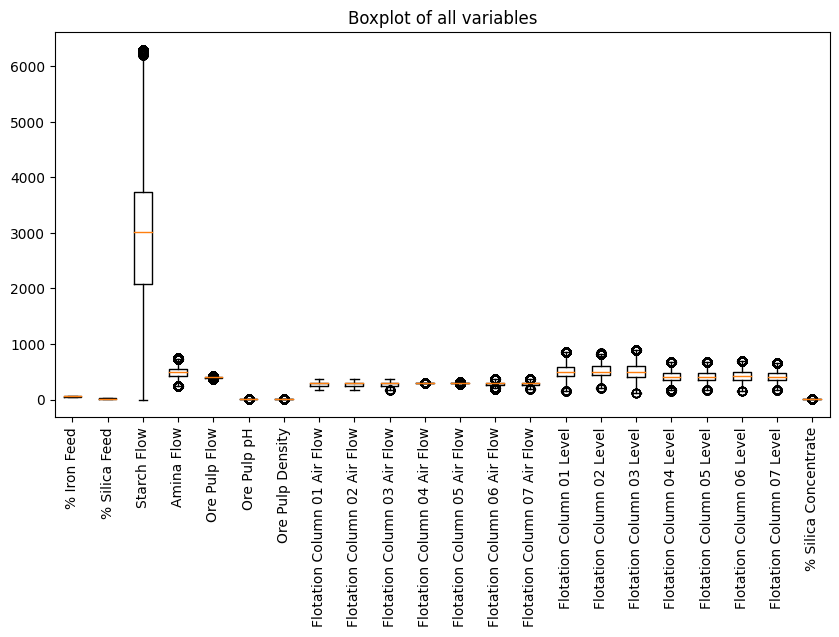

In [209]:
#drop iron concentrate - project requirement 
dataset = dataset.drop("% Iron Concentrate", axis=1)



dataset_wo_date = dataset.drop("date", axis=1)

plt.title("Boxplot of all variables")
plt.boxplot(dataset_wo_date)
plt.xticks(range(1, len(dataset_wo_date.columns) + 1), dataset_wo_date.columns.to_list(), rotation=90)
plt.show()


# Resolving timestamp problems

In [210]:
EXPECTED_SAMPLE_COUNT = 180

# determine which timestamps are incomplete
def determine_incomplete_dates(df):
    last_date = df.date.iloc[0]
    current_count = 1
    invalid_counts = []
    for date in df.date.iloc[1:]:
        if last_date == date:
            current_count += 1
        else:
            if current_count != EXPECTED_SAMPLE_COUNT:
                invalid_counts.append((last_date, current_count))
            last_date = date
            current_count = 1

    if invalid_counts:
        print("Timestamps with missing values:")
        for timestamp, count in invalid_counts:
            print(f"{timestamp}: {count} samples")
    else:
        print("All dates have correct number of samples")

determine_incomplete_dates(dataset)


Timestamps with missing values:
2017-03-10 01:00:00: 174 samples
2017-04-10 00:00:00: 179 samples


In [211]:
# remove first 174 rows, as the measurement is incomplete
dataset.drop(index=dataset.index[:174], axis=0, inplace=True)

# duplicate the last row of the date with 179 measurements
line = dataset.loc[dataset.date == "2017-04-10 00:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])
dataset = pd.concat([dataset.iloc[:iloc], line, dataset.iloc[iloc:]]).reset_index(drop=True)

In [212]:
determine_incomplete_dates(dataset)

All dates have correct number of samples


Timedelta 3600.0: 4094x
Timedelta 1148400.0: 1x


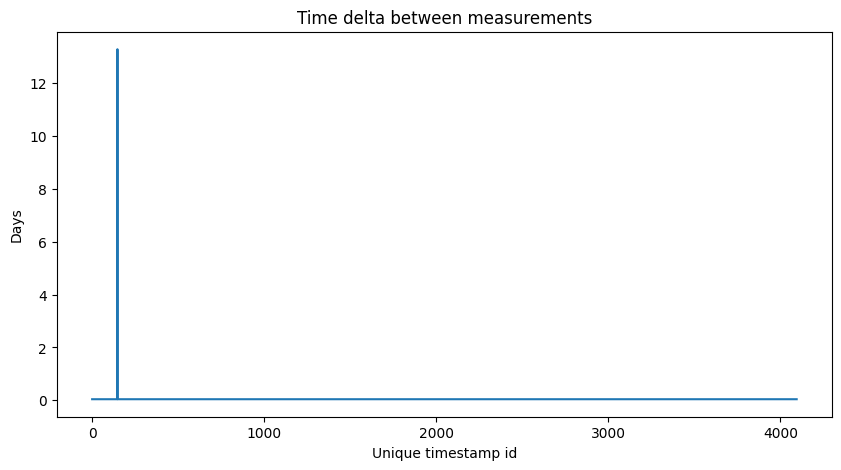

In [213]:
# check if timedelta is same throughout the dataset
def check_timedeltas(df):
    udates = df.date.unique()
    last = udates[0]
    timedeltas = []
    for date in udates[1:]:
        timedeltas.append((date-last) / np.timedelta64(1, 's'))
        last = date

    timedeltas = np.array(timedeltas)
    unique, counts = np.unique(timedeltas, return_counts=True)
    for value, count in zip(unique, counts):
        print(f"Timedelta {value}: {count}x")
    return timedeltas

timedeltas = check_timedeltas(dataset)
plt.title("Time delta between measurements")
plt.plot(timedeltas/60/60/24)
plt.xlabel("Unique timestamp id")
plt.ylabel("Days")
plt.show()

In [214]:
# find the gap
udates = dataset.date.unique()
last = udates[0]
for date in udates[1:]:
    if (date-last) / np.timedelta64(1, 's') != 3600.0:
        print(pd.to_datetime(last).strftime('%Y-%m-%d %H:%M:%S'))
    last = date
    

2017-03-16 05:00:00


In [215]:
line = dataset.loc[dataset.date == "2017-03-16 05:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])

dataset_small = dataset.iloc[:iloc+1]
dataset_big = dataset.iloc[iloc+1:]

In [216]:
_ = check_timedeltas(dataset_small)

Timedelta 3600.0: 147x


In [217]:
_ = check_timedeltas(dataset_big)

Timedelta 3600.0: 3947x


# Resampling

In [218]:
# determine which measurements were taken every hour
udate_count = len(udates)
skip_first = True
for name, values in dataset_big.items():
    if skip_first:
        skip_first = False
        continue

    count = len(values.unique())
    if count <= udate_count:
        print(f"Column \"{name}\" was probably sampled every hour")

Column "% Iron Feed" was probably sampled every hour
Column "% Silica Feed" was probably sampled every hour


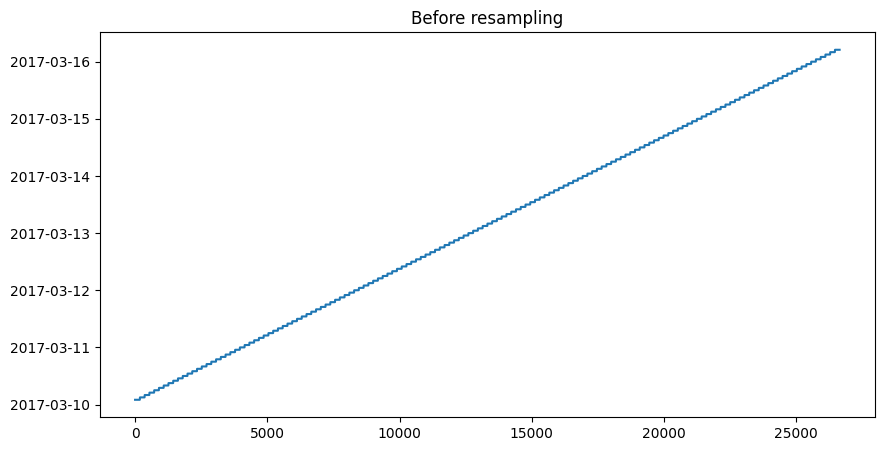

Resampling begin
Resampling column 1/3


100%|██████████| 147/147 [00:00<00:00, 1008.11it/s]


Resampling column 2/3


100%|██████████| 147/147 [00:00<00:00, 36676.15it/s]


Resampling column 3/3


100%|██████████| 147/147 [00:00<00:00, 20460.02it/s]


Resampling begin
Resampling column 1/3


100%|██████████| 3947/3947 [00:04<00:00, 966.60it/s] 


Resampling column 2/3


100%|██████████| 3947/3947 [00:00<00:00, 22800.31it/s]


Resampling column 3/3


100%|██████████| 3947/3947 [00:00<00:00, 18700.23it/s]


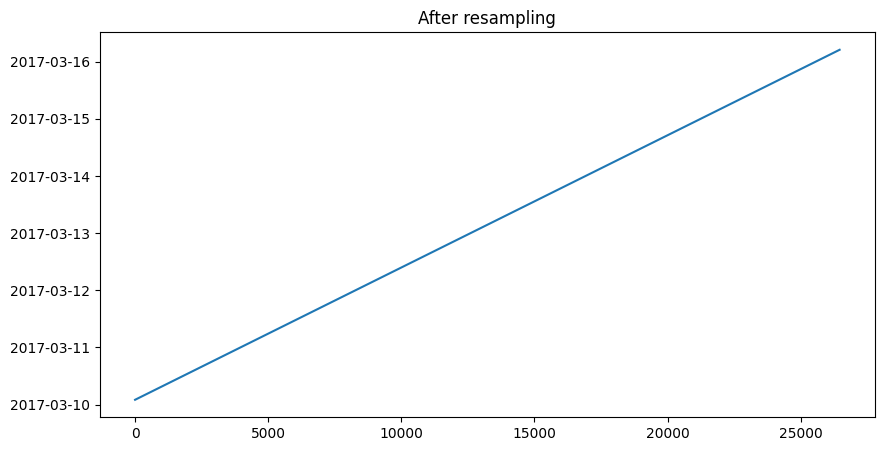

In [219]:
def resample(df: pd.DataFrame):
    print("Resampling begin")
    column_names = ["date", "% Iron Feed", "% Silica Feed"]
    for i, column_name in enumerate(column_names):
        print(f"Resampling column {i+1}/{len(column_names)}")
        column = df[column_name]
        column_iloc = dataset.columns.get_loc(column_name)
        values = column.values

        for i_batch in tqdm(range(0, column.size-EXPECTED_SAMPLE_COUNT, EXPECTED_SAMPLE_COUNT)):
            range_from = values[i_batch]
            range_to = values[i_batch+EXPECTED_SAMPLE_COUNT]
            delta = (range_to - range_from) / EXPECTED_SAMPLE_COUNT
            for i_item in range(EXPECTED_SAMPLE_COUNT):
                values[i_batch + i_item] = range_from + delta*i_item
        df.iloc[:,column_iloc]
    return df.copy()

plt.title("Before resampling")
plt.plot(dataset_small["date"])
plt.show()

dataset_small = resample(dataset_small)
dataset_big = resample(dataset_big)

# drop values that cannot be resampled
dataset_small.drop(index=dataset_small.index[-180:], axis=0, inplace=True)
dataset_big.drop(index=dataset_big.index[-180:], axis=0, inplace=True)

plt.title("After resampling")
plt.plot(dataset_small["date"])
plt.show()

In [220]:
dataset_big.reset_index(drop=True, inplace=True)

dataset_small_wo_date = dataset_small.drop("date", axis=1)
dataset_big_wo_date = dataset_big.drop("date", axis=1)




In [221]:
dataset_big['date'] = pd.to_datetime(dataset_big['date'])

tss = TimeSeriesSplit(n_splits = 2)

dataset_big.set_index('date', inplace=True)
dataset_big.sort_index(inplace=True)
X = dataset_big.iloc[:,:-1]
y = dataset_big.iloc[:,-1:]

for train_index, test_index in tss.split(X):
    X_calib, X_valid = X.iloc[train_index, :], X.iloc[test_index,:]
    y_calib, y_valid = y.iloc[train_index], y.iloc[test_index]





# split training set and center and scale every set


In [223]:

#center and scaling 
scaler = StandardScaler()
scaler.fit(X_calib)

# Scale the calibration data
scaled_train = scaler.transform(X_calib)
calib_set = pd.DataFrame(scaled_train, columns=X_calib.columns)

#scaling the validation data 
scaled_valid = scaler.transform(X_valid)
valid_set = pd.DataFrame(scaled_valid, columns=X_valid.columns)

#scaling the testing data 
X_test = dataset_small_wo_date.iloc[:,:-1]
y_test = dataset_small_wo_date.iloc[:,-1:]
scaled_test = scaler.transform(X_test)
testing_set = pd.DataFrame(scaled_test, columns=X_test.columns)

#center and scale output column 
scalerY = StandardScaler()
scalerY.fit(y_calib)

scaled_y_calib = scalerY.transform(y_calib)
calib_y = pd.DataFrame(scaled_y_calib, columns=y_calib.columns)

scaled_y_valid = scalerY.transform(y_valid)
valid_y = pd.DataFrame(scaled_y_valid, columns=y_valid.columns)

scaled_y_test = scalerY.transform(y_test)
testing_y = pd.DataFrame(scaled_y_test, columns=y_test.columns)






In [ ]:
import pca

model = pca.pca(normalize=True)
out = model.fit_transform(training_set, verbose=0)

KeyboardInterrupt: 

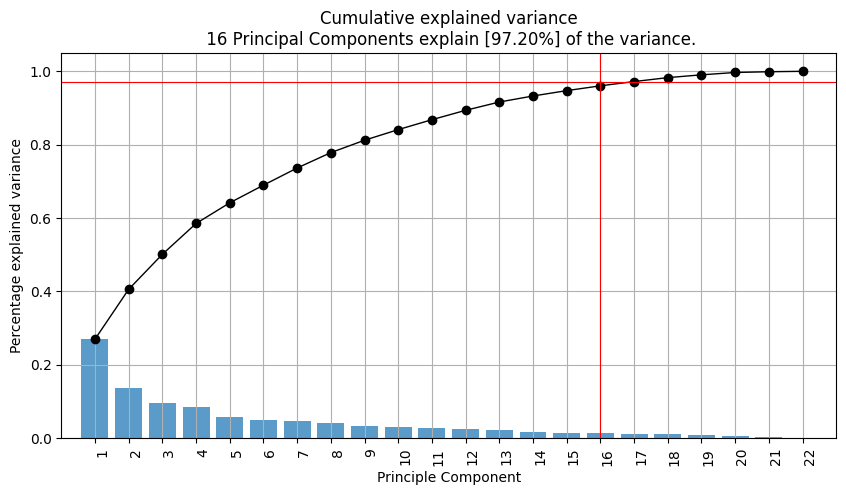

In [ ]:
fig, ax = plt.subplots()
model.plot(fig=fig,ax=ax)
plt.show()

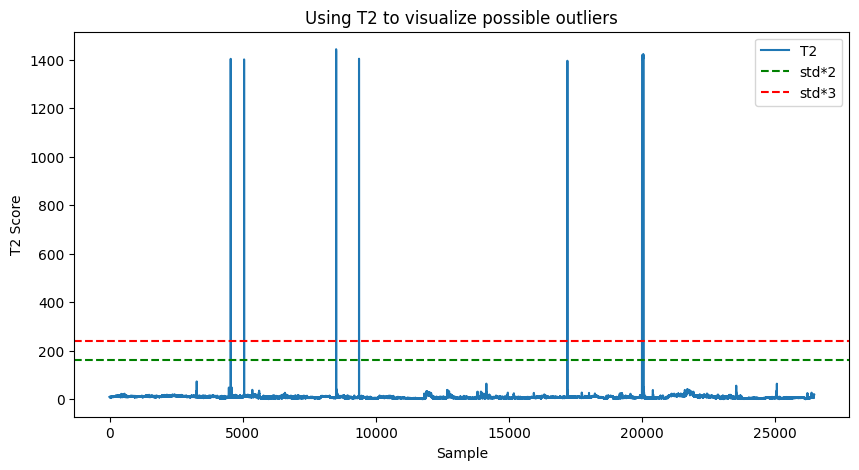

In [ ]:
PCA_NUM = 16

outliers_hot = pca.hotellingsT2(model_small.results['PC'].values[:,:PCA_NUM], verbose=0)
scores_t2 = outliers_hot[0]["y_score"]
mean_t2 = scores_t2.mean()
std_t2 = scores_t2.std()
plt.plot(scores_t2, label="T2")
plt.axhline(mean_t2 + 2*std_t2, color='g', linestyle='--', label='std*2')
plt.axhline(mean_t2 + 3*std_t2, color='r', linestyle='--', label='std*3')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('T2 Score')
plt.title('Using T2 to visualize possible outliers')
plt.show()

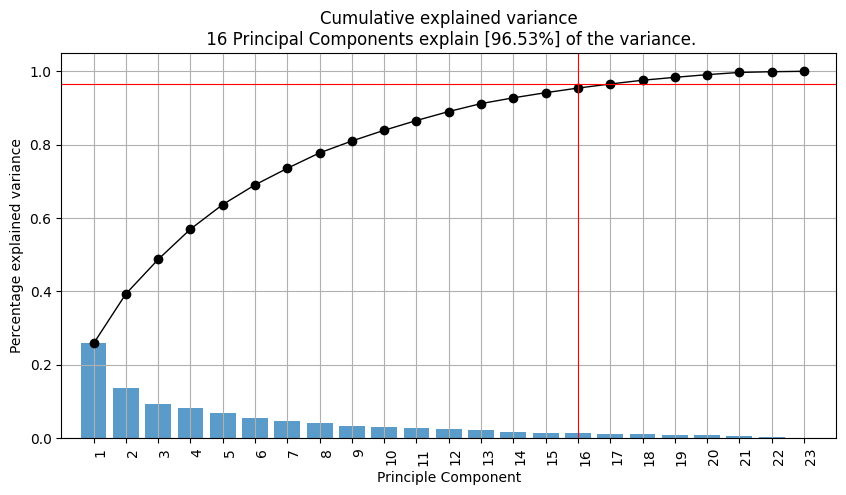

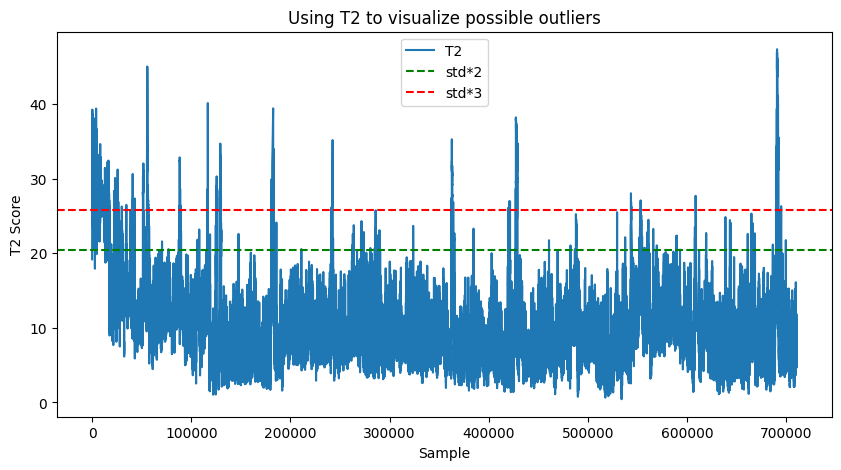

In [ ]:
model_big = pca.pca(normalize=True)
out = model_big.fit_transform(dataset_big_wo_date, verbose=0)

fig, ax = plt.subplots()
model_big.plot(fig=fig,ax=ax)
plt.show()

outliers_hot = pca.hotellingsT2(model_big.results['PC'].values[:,:PCA_NUM], verbose=0)
scores_t2 = outliers_hot[0]["y_score"]
mean_t2 = scores_t2.mean()
std_t2 = scores_t2.std()
plt.plot(scores_t2, label="T2")
plt.axhline(mean_t2 + 2*std_t2, color='g', linestyle='--', label='std*2')
plt.axhline(mean_t2 + 3*std_t2, color='r', linestyle='--', label='std*3')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('T2 Score')
plt.title('Using T2 to visualize possible outliers')
plt.show()

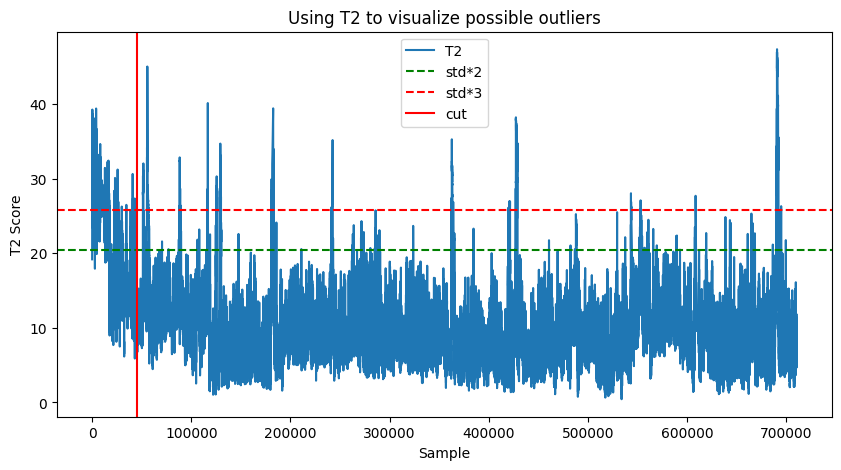

In [ ]:
CUT_INDEX = 45000

plt.plot(scores_t2, label="T2")
plt.axhline(mean_t2 + 2*std_t2, color='g', linestyle='--', label='std*2')
plt.axhline(mean_t2 + 3*std_t2, color='r', linestyle='--', label='std*3')
plt.axvline(CUT_INDEX, color='r', label='cut')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('T2 Score')
plt.title('Using T2 to visualize possible outliers')
plt.show()

In [ ]:
# # remove 45000 rows as majority of them was flagged as outliers, as the measurement is incomplete
# dataset_big.drop(index=dataset.index[:CUT_INDEX], axis=0, inplace=True)
# dataset_big_wo_date.drop(index=dataset.index[:CUT_INDEX], axis=0, inplace=True)

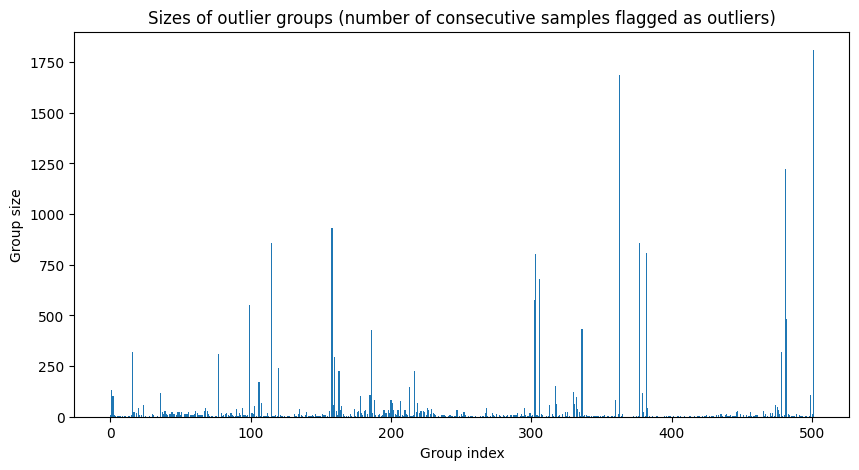

In [ ]:
scores = scores_t2.to_numpy()
indices = np.argwhere(scores > mean_t2 + 3*std_t2)
# indices = indices[indices > CUT_INDEX]

deltas = []
last = indices[0]
dc = 1
dgroups = []
for index in indices[1:-1]:
    d = index-last
    deltas.append(d)
    last = index
    if d == 1:
        dc+=1
    else:
        dgroups.append(dc)
        dc = 1    

plt.title("Sizes of outlier groups (number of consecutive samples flagged as outliers)")
plt.xlabel("Group index")
plt.ylabel("Group size")
plt.bar(range(len(dgroups)), dgroups)
plt.show()

In [ ]:
indices[0]

51163